      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  
(5110, 12)


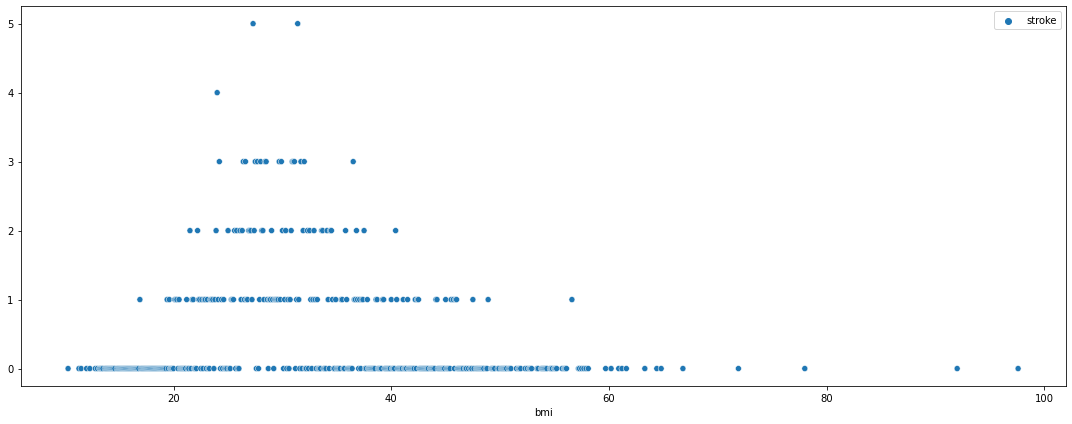

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt 
from scipy.stats import norm
from scipy.optimize import curve_fit
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import pairwise_distances
from sklearn.tree import DecisionTreeRegressor, export_graphviz

from sklearn.model_selection import train_test_split as split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
data = pd.read_csv(r'C:\Users\owner\Desktop\data analytics\project\archive\healthcare-dataset-stroke-data.csv') 
print(data.head())    
print(data.shape)
data.nunique()

#it seems there are no duplicate values in the data, since the id variable is unique to each person


#for bmi

fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  data.groupby('bmi')['stroke'].sum()
ax_data = ax_data.to_frame()
ax = sns.scatterplot(data=ax_data, color='blue', ax=ax)

plt.tight_layout()
plt.show()

In [2]:
#GENDER

#there are 3 unique values for gender
#print(data['gender'].value_counts())

#there is only 1 person with "Other" gender
#i will assume this was an error and leave this data point out of the analysis

other_index = data.index[data['gender']=='Other'].tolist()
print(other_index)

data1 = data.drop(index = 3116)
print(data1['gender'].value_counts())

#new dataframe contains only Female or Male

#next step is to encode the values to binary format in order to be used in the model
gen_data = pd.get_dummies(data1["gender"])
print(gen_data)

df = pd.concat([data1,gen_data], axis = 1)
df = df.drop(['gender','Male'], axis = 1)
df = df.rename(columns={'Female': 'gender'})
df

#0 = male, 1 = female

[3116]
Female    2994
Male      2115
Name: gender, dtype: int64
      Female  Male
0          0     1
1          1     0
2          0     1
3          1     0
4          1     0
...      ...   ...
5105       1     0
5106       1     0
5107       1     0
5108       0     1
5109       1     0

[5109 rows x 2 columns]


,id,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,gender
0,9046,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,0
1,51676,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,1
2,31112,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,0
3,60182,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,1
4,1665,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0,1
5106,44873,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0,1
5107,19723,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0,1
5108,37544,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0,0


never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: smoking_status, dtype: int64
         id   age  hypertension  heart_disease ever_married work_type  \
0     27419  59.0             0              0          Yes   Private   
1     60491  78.0             0              0          Yes   Private   
2      8213  78.0             0              1          Yes   Private   
3     25226  57.0             0              1           No  Govt_job   
4     64778  82.0             0              1          Yes   Private   
...     ...   ...           ...            ...          ...       ...   
1539    579   9.0             0              0           No  children   
1540  36901  45.0             0              0          Yes   Private   
1541  22127  18.0             0              0           No   Private   
1542  14180  13.0             0              0           No  children   
1543  44679  44.0             0              0          Yes  Govt_

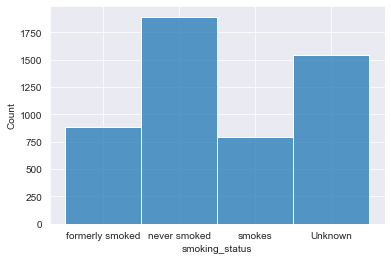

In [3]:
#SMOKING STATUS

#there are 4 unique values
#unknown values will be replaced with an estimate based on the distribution of the other 3 values
#0,1,2 will be the new values in this column (never, formerly, smokes)
sns.set_style('darkgrid')
sns.histplot(df['smoking_status'])

#there are 1544 'Unknown' values
howmanyu = df['smoking_status'].value_counts()
print(howmanyu)

#made new df with no unknown values
no_u = df.drop(df[df['smoking_status'] == 'Unknown'].index)

#take unknown data into another frame
data_grp = df.groupby('smoking_status').get_group('Unknown')
new_u = data_grp.drop(columns = ['smoking_status'])

#find corresponding % of each value
smoke_count = no_u['smoking_status'].value_counts(normalize = True)

def smoke_encoder(X):
    X['smoking_percent'] = list(map((lambda x: 0.53 if x == 'never smoked' else (0.25 if x == 'formerly smoked' else 0.22)), X.smoking_status))

smoke_transformer = FunctionTransformer(smoke_encoder)
smoke_transformer.transform(no_u)

#make 1544 new values to replace the "Unknown" values
sampled = no_u.sample(n = 1544,weights = 'smoking_percent',random_state=1,replace = True)
df_samples = sampled['smoking_status']

df_samples.reset_index(drop = True, inplace=True)
new_u.reset_index(drop = True, inplace=True)

newdf = new_u.join(df_samples)

#finally, lets replace string with integers (0,1,2)
def smoke_encoder1(X):
    X['smoking_status'] = list(map((lambda x: 0 if x == 'never smoked' else (1 if x == 'formerly smoked' else 2)), X.smoking_status))

smoke_transformer = FunctionTransformer(smoke_encoder1)
smoke_transformer.transform(newdf)
print(newdf)

In [4]:
#EVER_MARRIED

print(newdf['ever_married'].value_counts())

#lets convert these string data to binary similar to the process we took for 'gender' column
bin_data = pd.get_dummies(newdf["ever_married"])
newdf = pd.concat([newdf,bin_data], axis = 1)
newdf = newdf.drop(['ever_married','No'], axis = 1)
newdf = newdf.rename(columns={'Yes': 'ever_married'})
newdf



No     901
Yes    643
Name: ever_married, dtype: int64


,id,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,stroke,gender,smoking_status,ever_married
0,27419,59.0,0,0,Private,Rural,76.15,NaN,1,1,0,1
1,60491,78.0,0,0,Private,Urban,58.57,24.2,1,1,0,1
2,8213,78.0,0,1,Private,Urban,219.84,NaN,1,0,1,1
3,25226,57.0,0,1,Govt_job,Urban,217.08,NaN,1,0,0,0
4,64778,82.0,0,1,Private,Rural,208.30,32.5,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1539,579,9.0,0,0,children,Urban,71.88,17.5,0,0,0,0
1540,36901,45.0,0,0,Private,Urban,97.95,24.5,0,1,0,1
1541,22127,18.0,0,0,Private,Urban,82.85,46.9,0,1,0,0
1542,14180,13.0,0,0,children,Rural,103.08,18.6,0,1,0,0


In [5]:
#RESIDENCE TYPE
print(newdf['Residence_type'].value_counts())

#lets convert these string data to binary [again]
bin_data = pd.get_dummies(newdf["Residence_type"])
newdf = pd.concat([newdf,bin_data], axis = 1)
newdf = newdf.drop(['Residence_type','Rural'], axis = 1)
newdf = newdf.rename(columns={'Urban': 'residence_type'})
newdf


Urban    782
Rural    762
Name: Residence_type, dtype: int64


,id,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,stroke,gender,smoking_status,ever_married,residence_type
0,27419,59.0,0,0,Private,76.15,NaN,1,1,0,1,0
1,60491,78.0,0,0,Private,58.57,24.2,1,1,0,1,1
2,8213,78.0,0,1,Private,219.84,NaN,1,0,1,1,1
3,25226,57.0,0,1,Govt_job,217.08,NaN,1,0,0,0,1
4,64778,82.0,0,1,Private,208.30,32.5,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1539,579,9.0,0,0,children,71.88,17.5,0,0,0,0,1
1540,36901,45.0,0,0,Private,97.95,24.5,0,1,0,1,1
1541,22127,18.0,0,0,Private,82.85,46.9,0,1,0,0,1
1542,14180,13.0,0,0,children,103.08,18.6,0,1,0,0,0


Private          640
children         618
Self-employed    156
Govt_job         122
Never_worked       8
Name: work_type, dtype: int64
work_type
Govt_job         0.065574
Never_worked     0.000000
Private          0.045312
Self-employed    0.051282
children         0.003236
Name: stroke, dtype: float64


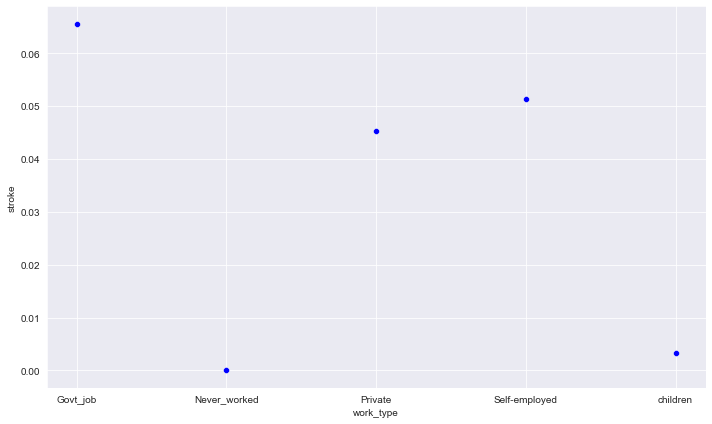

,id,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,stroke,gender,smoking_status,ever_married,residence_type
0,27419,59.0,0,0,5,76.15,NaN,1,1,0,1,0
1,60491,78.0,0,0,5,58.57,24.2,1,1,0,1,1
2,8213,78.0,0,1,5,219.84,NaN,1,0,1,1,1
3,25226,57.0,0,1,2,217.08,NaN,1,0,0,0,1
4,64778,82.0,0,1,5,208.30,32.5,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1539,579,9.0,0,0,4,71.88,17.5,0,0,0,0,1
1540,36901,45.0,0,0,5,97.95,24.5,0,1,0,1,1
1541,22127,18.0,0,0,5,82.85,46.9,0,1,0,0,1
1542,14180,13.0,0,0,4,103.08,18.6,0,1,0,0,0


In [6]:
#WORK_TYPE
print(newdf['work_type'].value_counts())

ax_data = newdf.groupby('work_type')['stroke'].mean()
print(ax_data)


fig, ax = plt.subplots(1, figsize=(10, 6), sharey=True, sharex = True)
ax = sns.scatterplot(data=ax_data, color='blue', ax=ax)
plt.tight_layout()
plt.show()

#lets convert these string data to numerical values (1,2,3,4,5)

def work_encoder(X):
    X['work_type'] = list(map((lambda x: 1 if x == 'Never_worked' else 2 if x == 'Govt_job' else 3 if x == 'Self_employed' else(4 if x == 'children' else 5)), X.work_type))

work_transformer = FunctionTransformer(work_encoder)
work_transformer.transform(newdf)
newdf

In [7]:
#BMI 

#there are 61 null values for bmi
print(newdf['bmi'].isnull().sum())

#lets replace the null values with the mean of all bmi values
themean = newdf["bmi"].mean() 
newdf['bmi'] = newdf['bmi'].fillna(61)
newdf


61


,id,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,stroke,gender,smoking_status,ever_married,residence_type
0,27419,59.0,0,0,5,76.15,61.0,1,1,0,1,0
1,60491,78.0,0,0,5,58.57,24.2,1,1,0,1,1
2,8213,78.0,0,1,5,219.84,61.0,1,0,1,1,1
3,25226,57.0,0,1,2,217.08,61.0,1,0,0,0,1
4,64778,82.0,0,1,5,208.30,32.5,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1539,579,9.0,0,0,4,71.88,17.5,0,0,0,0,1
1540,36901,45.0,0,0,5,97.95,24.5,0,1,0,1,1
1541,22127,18.0,0,0,5,82.85,46.9,0,1,0,0,1
1542,14180,13.0,0,0,4,103.08,18.6,0,1,0,0,0


<AxesSubplot:>

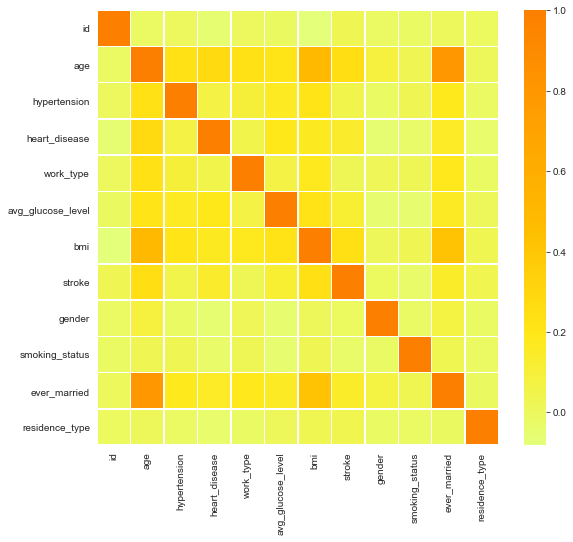

In [8]:
#correlation matrix shows relation between different numerical variables in the data
corrmatrix = newdf.corr()
f, ax = plt.subplots(figsize =(9, 8))
sns.heatmap(corrmatrix, ax = ax, cmap ="Wistia", linewidths = 0.5)

In [14]:
#Classification Models 75-25 test ratio
x = newdf[['age', 'hypertension', 'heart_disease', 'work_type', 'avg_glucose_level','bmi', 'gender', 'smoking_status', 'ever_married', 'residence_type']]
y = newdf['stroke']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25,random_state = 0)
#Logistic Regression
logreg = LogisticRegression()
logreg.fit(x_train,y_train)
y_pred = logreg.predict(x_test)
print('Mean Absolute Error:', mae(y_test, y_pred))  
print('Mean Squared Error:', mse(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mse(y_test, y_pred)))
print('β0 is: ', logreg.intercept_)
print('β1 is: ', logreg.coef_) 
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('%d  is misclassified out of %d '%(np.sum(confusion_matrix(y_test, y_pred))-np.sum(np.diag(confusion_matrix(y_test, y_pred))), x_test.shape[0]))

#KNN 3 neighbors
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train,y_train)
y_pred = knn.predict(x_test)
print('KNN:')
print('Mean Absolute Error:', mae(y_test, y_pred))  
print('Mean Squared Error:', mse(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mse(y_test, y_pred)))
print("Score for Number of Neighbors = 3: {}".format(knn.score(x_test,y_test)))
#SVM
svm = SVC(random_state=0)
svm.fit(x_train,y_train)
y_pred_svm = svm.predict(x_test)
print('SVM:')
print('Mean Absolute Error:', mae(y_test, y_pred_svm))  
print('Mean Squared Error:', mse(y_test, y_pred_svm))  
print('Root Mean Squared Error:', np.sqrt(mse(y_test, y_pred_svm)))
print("Score for SVM: ", svm.score(x_test,y_test))

Mean Absolute Error: 0.03626943005181347
Mean Squared Error: 0.03626943005181347
Root Mean Squared Error: 0.1904453466268301
β0 is:  [-8.24684176]
β1 is:  [[ 0.07870902 -0.54874434 -1.31913978 -0.17354703  0.00256496  0.05769462
  -0.32225814 -0.7183905  -0.53942447  0.1690411 ]]
Confusion matrix: 
 [[370   0]
 [ 14   2]]
14  is misclassified out of 386 
KNN:
Mean Absolute Error: 0.04145077720207254
Mean Squared Error: 0.04145077720207254
Root Mean Squared Error: 0.20359463942371503
Score for Number of Neighbors = 3: 0.9585492227979274
SVM:
Mean Absolute Error: 0.04145077720207254
Mean Squared Error: 0.04145077720207254
Root Mean Squared Error: 0.20359463942371503
Score for SVM:  0.9585492227979274


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
